# Fashion MINST Data Set in imagenet layout

I am trying out the 2019 version of the fast.ai MOOC that is currently available here: https://course.fast.ai/

This is my playground project that leverages the fashion MINST dataset from kaggle available here: https://www.kaggle.com/zalando-research/fashionmnist

I have reorganized the data to be layed out ImageNet style - here are the number to labels to (folder) mappings:

```
0 T-shirt/top (tshirt_top)
1 Trouser     (trouser)
2 Pullover    (pullover)
3 Dress       (dress)
4 Coat        (coat)
5 Sandal      (sandal)
6 Shirt       (shirt)
7 Sneaker     (sneaker)
8 Bag         (bag)
9 Ankle boot  (ankle_boot)
```
NOTE: since I don't own the data, I am not reposting data, only results!

In [85]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [86]:
from fastai.vision import *
from fastai.metrics import error_rate

In [87]:
bs = 64
sz = 28
vp = 0.2
root_dir = '/storage/fashion_mnist'

In [88]:
data = ImageDataBunch.from_folder(root_dir, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=vp)

In [89]:
data = data.normalize(imagenet_stats)

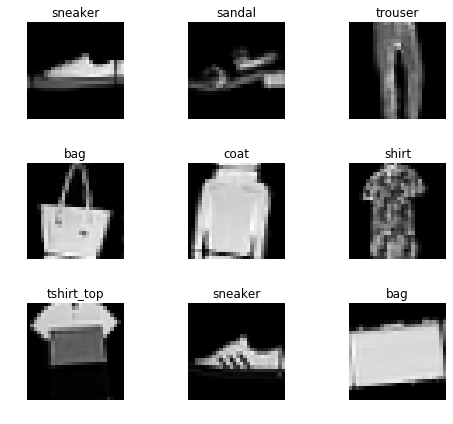

In [90]:
data.show_batch(rows=3, figsize=(7,6))

In [91]:
print(data.classes)
len(data.classes),data.c

['ankle_boot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt_top']


(10, 10)

**NOTE: I know the lesson does not recommend unfreezing at the beginning, but this seems to generate the best model!**

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.unfreeze()
learn.fit_one_cycle(6)
learn.save('fashion_mnist_v1:stage0')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:06<00:00, 13936037.57it/s]


epoch,train_loss,valid_loss,error_rate
1,0.512200,0.392749,0.143286
2,0.412890,0.303940,0.109429
3,0.346836,0.277882,0.101214
4,0.306161,0.237423,0.086143
5,0.249138,0.218458,0.079643
6,0.240044,0.208729,0.077000


In [15]:
interp = ClassificationInterpretation.from_learner(learn)

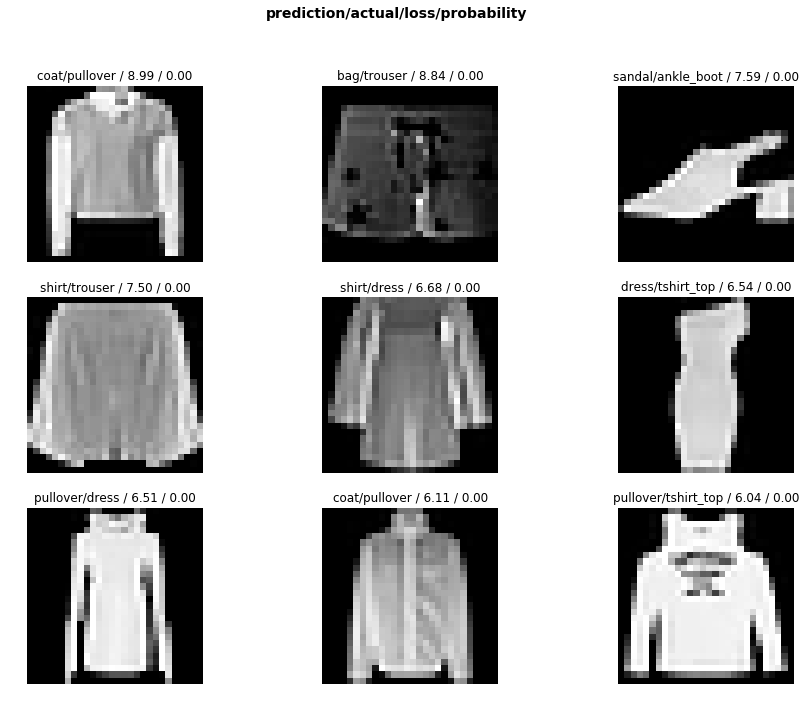

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

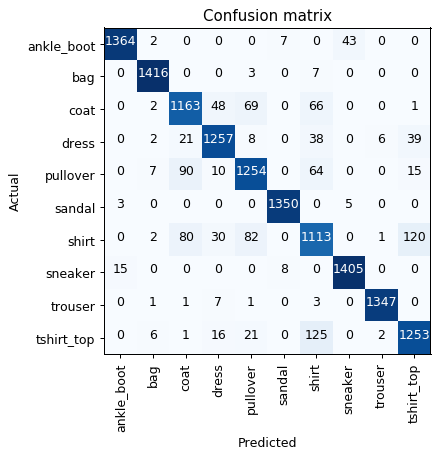

In [83]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

In [18]:
interp.most_confused(min_val=2)

[('tshirt_top', 'shirt', 125),
 ('shirt', 'tshirt_top', 120),
 ('pullover', 'coat', 90),
 ('shirt', 'pullover', 82),
 ('shirt', 'coat', 80),
 ('coat', 'pullover', 69),
 ('coat', 'shirt', 66),
 ('pullover', 'shirt', 64),
 ('coat', 'dress', 48),
 ('ankle_boot', 'sneaker', 43),
 ('dress', 'tshirt_top', 39),
 ('dress', 'shirt', 38),
 ('shirt', 'dress', 30),
 ('dress', 'coat', 21),
 ('tshirt_top', 'pullover', 21),
 ('tshirt_top', 'dress', 16),
 ('pullover', 'tshirt_top', 15),
 ('sneaker', 'ankle_boot', 15),
 ('pullover', 'dress', 10),
 ('dress', 'pullover', 8),
 ('sneaker', 'sandal', 8),
 ('ankle_boot', 'sandal', 7),
 ('bag', 'shirt', 7),
 ('pullover', 'bag', 7),
 ('trouser', 'dress', 7),
 ('dress', 'trouser', 6),
 ('tshirt_top', 'bag', 6),
 ('sandal', 'sneaker', 5),
 ('bag', 'pullover', 3),
 ('sandal', 'ankle_boot', 3),
 ('trouser', 'shirt', 3)]

## Check the error rate on test data

In [32]:
data_test = ImageDataBunch.from_folder(root_dir, ds_tfms=get_transforms(), size=sz, bs=bs, valid='test')

In [34]:
data_test = data_test.normalize(imagenet_stats)

In [35]:
print(data_test.classes)

['ankle_boot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt_top']


In [78]:
# change the data in learn
learn.data = data_test
# interpret with this new data from learn
interp_test = ClassificationInterpretation.from_learner(learn)

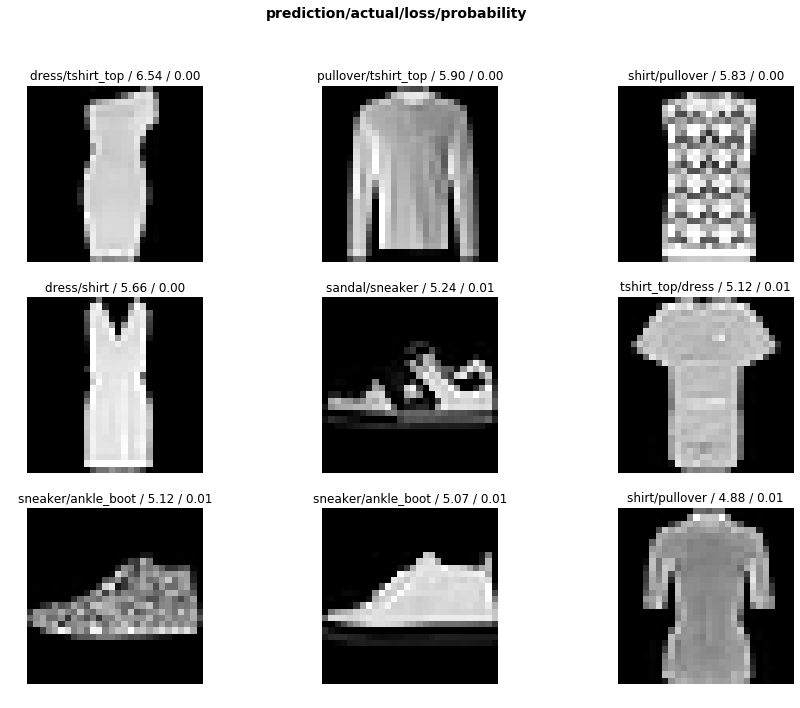

In [80]:
interp_test.plot_top_losses(9, figsize=(15,11))

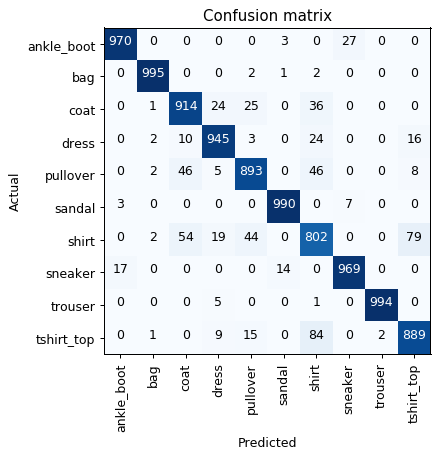

In [82]:
interp_test.plot_confusion_matrix(figsize=(5,5), dpi=90)

In [41]:
interp_test.most_confused(min_val=2)

[('tshirt_top', 'shirt', 84),
 ('shirt', 'tshirt_top', 79),
 ('shirt', 'coat', 54),
 ('pullover', 'coat', 46),
 ('pullover', 'shirt', 46),
 ('shirt', 'pullover', 44),
 ('coat', 'shirt', 36),
 ('ankle_boot', 'sneaker', 27),
 ('coat', 'pullover', 25),
 ('coat', 'dress', 24),
 ('dress', 'shirt', 24),
 ('shirt', 'dress', 19),
 ('sneaker', 'ankle_boot', 17),
 ('dress', 'tshirt_top', 16),
 ('tshirt_top', 'pullover', 15),
 ('sneaker', 'sandal', 14),
 ('dress', 'coat', 10),
 ('tshirt_top', 'dress', 9),
 ('pullover', 'tshirt_top', 8),
 ('sandal', 'sneaker', 7),
 ('pullover', 'dress', 5),
 ('trouser', 'dress', 5),
 ('ankle_boot', 'sandal', 3),
 ('dress', 'pullover', 3),
 ('sandal', 'ankle_boot', 3)]

In [74]:
num_errors = sum((interp_test.pred_class != interp_test.y_true).numpy())
total = list(interp_test.pred_class.size())[0]

In [77]:
print("Error rate =", num_errors/total)

Error rate = 0.0639


## Result

Not bad... the test error rate is quite similar to the validation error rate... so we haven't overfit to the training data!

NOTE: An error rate of 6.4% is not spectacular, but the images are really very low-res... there is going to be a limit to what we can extract and the top-losses seem quite plausible!

# Appendix - Let's Try the Lesson Approach

We want to start with a frozen model on the same data and see how it trains.

In [92]:
learn2 = create_cnn(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.883978,0.727833,0.268857
2,0.643542,0.542223,0.207357
3,0.559959,0.462107,0.173143
4,0.564019,0.452347,0.168429


In [93]:
learn2.save('fashion_mnist_v1:appendix:stage0')

In [95]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


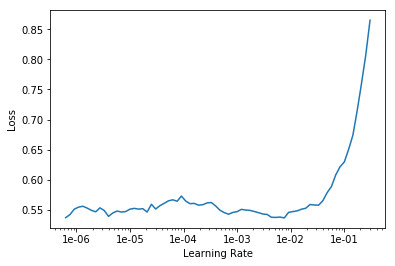

In [97]:
learn2.recorder.plot()

In [98]:
learn2.unfreeze()
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.479277,0.410615,0.149357
2,0.365893,0.312414,0.120071


The observation is that after 6 epochs of training we only got to a 12% error rate vs a 6.4% error rate. Perhaps this is because of the low-res nature of the images? That maybe a question for another day!